In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("eurosat", with_info=True, as_supervised=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.5A7Z33_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
import tensorflow as tf

# Image and batch settings
IMG_SIZE = 128
BATCH_SIZE = 32

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Train / validation split
train_size = int(0.8 * info.splits['train'].num_examples)

train_ds = dataset['train'].take(train_size)
val_ds = dataset['train'].skip(train_size)

# Performance tuning
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTOTUNE)
)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')
])


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.4020 - loss: 1.6343 - val_accuracy: 0.5913 - val_loss: 1.1611
Epoch 2/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.6554 - loss: 0.9716 - val_accuracy: 0.7011 - val_loss: 0.7914
Epoch 3/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7102 - loss: 0.8134 - val_accuracy: 0.7343 - val_loss: 0.7168


In [ ]:
model.save("eurosat_cnn_v1.h5")


In [ ]:
from google.colab import files
files.download("eurosat_cnn_v1.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7331 - loss: 0.7157
Validation Accuracy: 73.43%
Validation Loss: 0.7168


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step


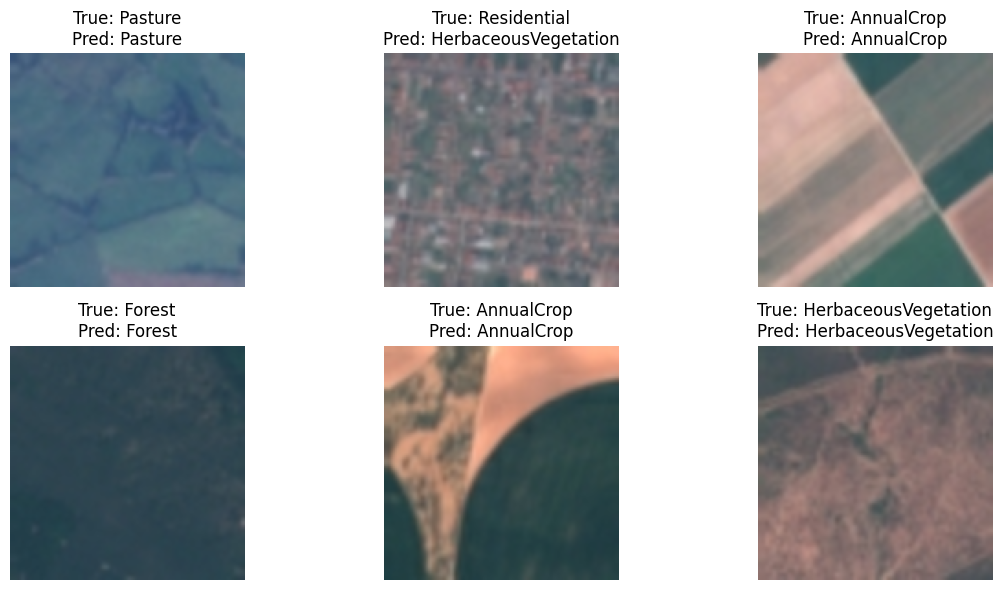

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_names = info.features['label'].names

for images, labels in val_ds.take(1):
    predictions = model.predict(images)

    plt.figure(figsize=(12, 6))

    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(
            f"True: {class_names[labels[i]]}\nPred: {class_names[np.argmax(predictions[i])]}"
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)


Epoch 1/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7654 - loss: 0.6599 - val_accuracy: 0.7557 - val_loss: 0.6745
Epoch 2/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8019 - loss: 0.5650 - val_accuracy: 0.7915 - val_loss: 0.5683
Epoch 3/3
675/675 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8329 - loss: 0.4769 - val_accuracy: 0.7741 - val_loss: 0.6194


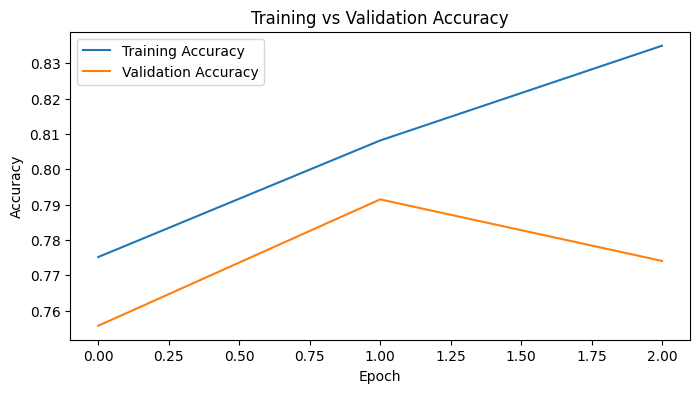

In [ ]:
plt.figure(figsize=(8,4))

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()
